In [1]:

import uproot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit
import ROOT
from colorama import Fore, Style, init
init(autoreset=True)

import numpy as np

def baseline_subtract(pulse, n_baseline=16):
    """
    Subtracts baseline from a pulse.
    n_baseline: number of samples at start used to estimate baseline
    """
    baseline = np.median(pulse[:n_baseline])
    return pulse - baseline
    
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2))
    
def crystalball(x, alpha, n, mean, sigma, N):
    # (N = normalization)
    z = (x - mean) / sigma
    if isinstance(z, np.ndarray):
        result = np.zeros_like(z)
    else:
        result = 0

    # Transition point
    mask = z > -alpha

    # Gaussian region
    result[mask] = N * np.exp(-0.5 * z[mask]**2)

    # Power-law tail region
    A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
    B = n / abs(alpha) - abs(alpha)
    result[~mask] = N * A * (B - z[~mask])**(-n)

    return result

def cb_plus_const(x, alpha, n, mu, sigma, N, C):
    return crystalball(x, alpha, n, mu, sigma, N) + C

def ReadProcessedFile(filename,treeName="treeML",paramType=True):
    file = uproot.open(filename)
    tree = file[treeName]
    treeData = tree.arrays(["t0","t1","t2","t3","q0","q1","q2","q3","samples0","samples2"],library="np")
    param_list02=[]
    param_list13=[]
    for i in range(len(treeData["q0"])):
        if paramType:
            param_list02.append((np.float64(treeData["t0"][i])-np.float64(treeData["t2"][i]))/1000.)
            param_list13.append((np.float64(treeData["t1"][i])-np.float64(treeData["t3"][i]))/1000.)
        else:
            param_list02.append(math.log(treeData["q2"][i]/treeData["q0"][i]))
            param_list13.append(math.log(treeData["q1"][i]/treeData["q3"][i]))
            '''
            pulse0=treeData["samples0"]
            pulse2=treeData["samples2"]
            for i in range(len(pulse0)):
                param_list02.append(math.log(np.min(baseline_subtract(pulse2[i]))/np.min(baseline_subtract(pulse0[i]))))
                #param_list13.append(math.log(np.min(baseline_subtract(pulse3[i]))/np.min(baseline_subtract(pulse1[i]))))
            '''
            
        '''
        if paramType == 0:
            param_list02.append(treeData["t0"][i]-treeData["t2"][i])
            param_list13.append(treeData["t1"][i]-treeData["t3"][i])
        elif paramType == 1:
            param_list02.append(math.log(treeData["q2"][i]/treeData["q0"][i]))
            param_list13.append(math.log(treeData["q1"][i]/treeData["q3"][i]))
        elif paramType == 2:
            pulse0=treeData["samples0"]
            pulse2=treeData["samples2"]
            for i in range(len(pulse0)):
                param_list02.append(math.log(np.min(baseline_subtract(pulse2[i]))/np.min(baseline_subtract(pulse0[i]))))
                #param_list13.append(math.log(np.min(baseline_subtract(pulse3[i]))/np.min(baseline_subtract(pulse1[i]))))
        '''
            
        
    return param_list02,param_list13

def MakeHistogramAndFit(param_list,index=0):
    binss=np.linspace(-2,2,100)
    #counts, bins, _ =plt.hist(param_list,bins=binss,histtype='step',color='blue')
    counts, bins, _ =plt.hist(param_list,bins=100,histtype='step',color='blue')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    # Initial guess for fit parameters: A, mean, sigma
    p0 = [max(counts), np.mean(param_list), np.std(param_list)]
    # Fit using curve_fit
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=p0)
    # Extract fit results
    A_fit, mu_fit, sigma_fit = popt
    #print(f"Fit results for file at Position={index}, A={A_fit:.2f}, mu={mu_fit:.2f}, sigma={sigma_fit:.2f}")
    return popt,bins

def PlotFit(dist,popt,bins):
    x_fit = np.linspace(min(bins), max(bins), 1000)
    y_fit = dist(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r--', linewidth=2, label='Gaussian Fit')

def FitPolynomial(listx,listy):
    plt.plot(listx,listy,"o",color='red')
    #print(listx)
    coeffs = np.polyfit(listx, listy, 3)  # degree = 3
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(listx), max(listx), 500)
    y_fit = poly(x_fit)
    plt.plot(x_fit, y_fit, 'b--', label="3rd Order Fit")
    return poly
    

Welcome to JupyROOT 6.30/04


Mean of Evaluated :  -0.3315097740624415
Sigma of Evaluated :  7.907276850477603


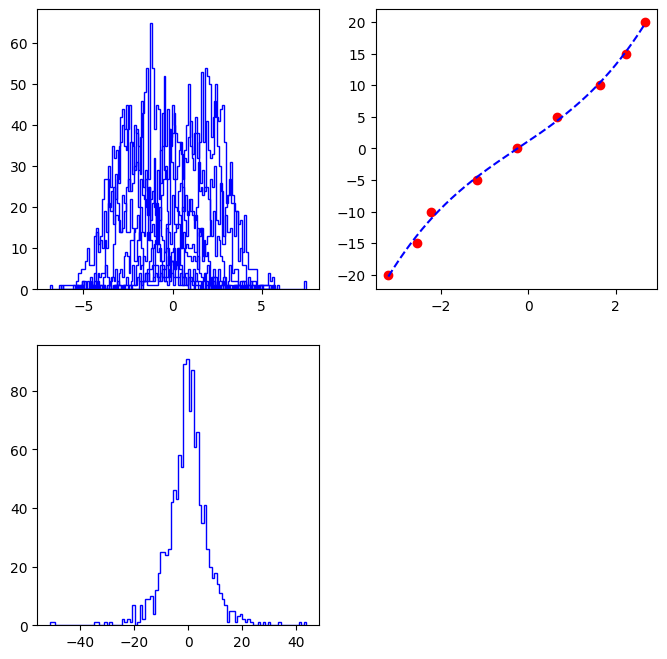

In [2]:
base_path="/home/rsehgal/shared/SquareScint/CPP/build/"
file_list=["Muon_output_0_-20.root","Muon_output_0_-15.root","Muon_output_0_-10.root","Muon_output_0_-5.root","Muon_output_0_0.root","Muon_output_0_5.root","Muon_output_0_10.root","Muon_output_0_15.root","Muon_output_0_20.root"]
loc_list = [-20,-15,-10,-5,0,5,10,15,20]

#file_list=["Muon_output_-10_-20.root","Muon_output_-10_-10.root","Muon_output_-10_0.root","Muon_output_-10_10.root","Muon_output_-10_20.root"]
#loc_list = [-20,-10,0,10,20]

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
mean_list=[]
paramType=True
for index in range(len(file_list)):
    param_list02,param_list13 = ReadProcessedFile(base_path+file_list[index],paramType=paramType)
    popt,bins=MakeHistogramAndFit(param_list02,index)
    A_fit, mu_fit, sigma_fit = popt
    mean_list.append(mu_fit)
    #PlotFit(gaussian,popt,bins)

plt.subplot(2,2,2)
fittedPoly=FitPolynomial(mean_list,loc_list)
param_list02,param_list13 = ReadProcessedFile(base_path+file_list[4],paramType=paramType)
evaluatedResult=fittedPoly(param_list02)
print("Mean of Evaluated : ",np.mean(evaluatedResult))
print("Sigma of Evaluated : ",np.std(evaluatedResult))

plt.subplot(2,2,3)
plt.hist(evaluatedResult,bins=100,histtype='step',color='blue')
    
'''
plt.subplot(2,2,2)
param_list02,param_list13 = ReadProcessedFile(base_path+file_list[5],timing=True)
popt,bins=MakeHistogramAndFit(param_list02)
PlotFit(gaussian,popt,bins)
'''
#plt.hist(param_list02,bins=100,histtype='step', color='blue')
plt.show()



Plane for X_phys: X = -10.193*ΔTx + -0.269*ΔTy + 8.041
Plane for Y_phys: Y = 0.300*ΔTx + 8.075*ΔTy + 1.066
TEST OUTPUT :  (np.float64(27.755967278022833), np.float64(20.65532334762534))


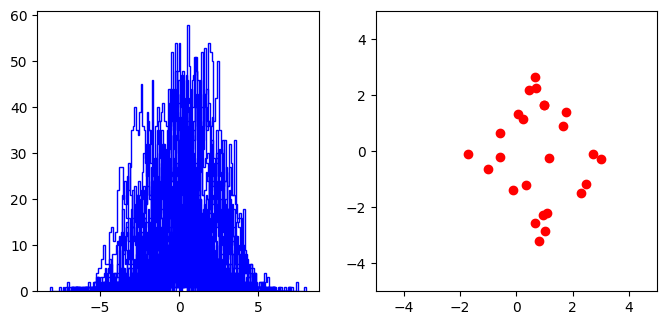

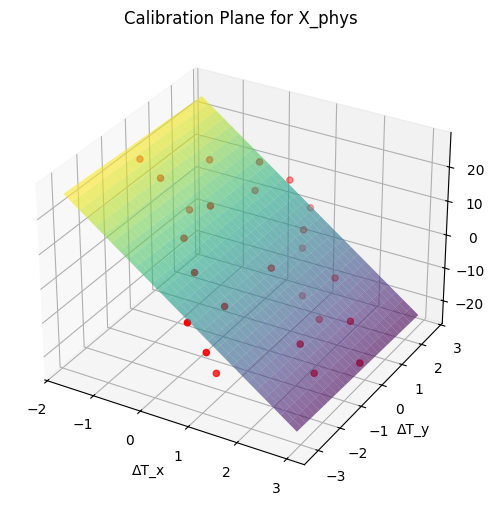

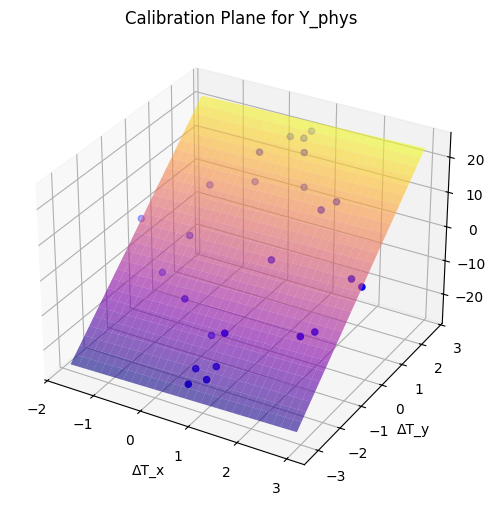

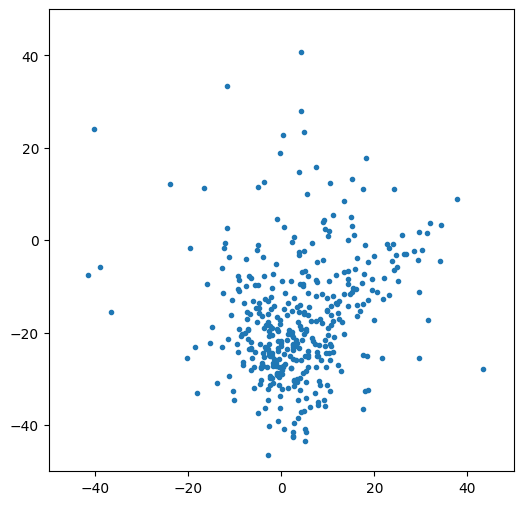

In [9]:
from sklearn.linear_model import LinearRegression

base_path="/home/rsehgal/shared/SquareScint/CPP/build/"
file_list=["Muon_output_0_-20.root","Muon_output_0_-15.root","Muon_output_0_-10.root","Muon_output_0_-5.root","Muon_output_0_0.root","Muon_output_0_5.root","Muon_output_0_10.root","Muon_output_0_15.root","Muon_output_0_20.root"]
file_list=[]
#loc_list = [-20,-15,-10,-5,0,5,10,15,20]
loc_list = [-20,-10,0,10,20]
X_phys = []
Y_phys = []
for i in loc_list:
    for j in loc_list:
        X_phys.append(i)
        Y_phys.append(j)
        file_list.append("Muon_output_"+str(i)+"_"+str(j)+".root")

'''
print("================ Going to process following files =================")
for filename in file_list:
    print(filename)

print("=============== Starting =================")
'''
#file_list=["Muon_output_-10_-20.root","Muon_output_-10_-10.root","Muon_output_-10_0.root","Muon_output_-10_10.root","Muon_output_-10_20.root"]
#loc_list = [-20,-10,0,10,20]

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
mean_list02=[]
mean_list13=[]
paramType=True
for index in range(len(file_list)):
    param_list02,param_list13 = ReadProcessedFile(base_path+file_list[index],paramType=paramType)
    
    popt,bins=MakeHistogramAndFit(param_list02,index)
    A_fit, mu_fit, sigma_fit = popt
    mean_list02.append(mu_fit)

    popt,bins=MakeHistogramAndFit(param_list13,index)
    A_fit, mu_fit, sigma_fit = popt
    mean_list13.append(mu_fit)
    

plt.subplot(2,2,2)
plt.plot(mean_list13,mean_list02,"o", color='red')
plt.xlim(-5,5)
plt.ylim(-5,5)

# ----------------------
# Fit planes using least squares
# ----------------------
A = np.column_stack([mean_list13, mean_list02, np.ones_like(mean_list13)])

coef_x, *_ = np.linalg.lstsq(A, X_phys, rcond=None)  # plane coefficients for X_phys
coef_y, *_ = np.linalg.lstsq(A, Y_phys, rcond=None)  # plane coefficients for Y_phys

print(f"Plane for X_phys: X = {coef_x[0]:.3f}*ΔTx + {coef_x[1]:.3f}*ΔTy + {coef_x[2]:.3f}")
print(f"Plane for Y_phys: Y = {coef_y[0]:.3f}*ΔTx + {coef_y[1]:.3f}*ΔTy + {coef_y[2]:.3f}")

# ----------------------
# Make a grid for smooth surface
# ----------------------
grid_tx = np.linspace(np.min(mean_list13), np.max(mean_list13), 30)
grid_ty = np.linspace(np.min(mean_list02), np.max(mean_list02), 30)
GTX, GTY = np.meshgrid(grid_tx, grid_ty)

GX = coef_x[0]*GTX + coef_x[1]*GTY + coef_x[2]  # plane for X_phys
GY = coef_y[0]*GTX + coef_y[1]*GTY + coef_y[2]  # plane for Y_phys

# ----------------------
# Plot 1: Plane for X_phys
# ----------------------
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(GTX, GTY, GX, alpha=0.6, cmap='viridis')
ax1.scatter(mean_list13, mean_list02, X_phys, color='red')  # calibration points
ax1.set_xlabel("ΔT_x")
ax1.set_ylabel("ΔT_y")
ax1.set_zlabel("X_phys")
ax1.set_title("Calibration Plane for X_phys")

# ----------------------
# Plot 2: Plane for Y_phys
# ----------------------
fig2 = plt.figure(figsize=(7, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(GTX, GTY, GY, alpha=0.6, cmap='plasma')
ax2.scatter(mean_list13, mean_list02, Y_phys, color='blue')  # calibration points
ax2.set_xlabel("ΔT_x")
ax2.set_ylabel("ΔT_y")
ax2.set_zlabel("Y_phys")
ax2.set_title("Calibration Plane for Y_phys")

GTX=-2.0
GTY=2.5
GX = coef_x[0]*GTX + coef_x[1]*GTY + coef_x[2]  # plane for X_phys
GY = coef_y[0]*GTX + coef_y[1]*GTY + coef_y[2]  # plane for Y_phys
print("TEST OUTPUT : ",(GX,GY))

#Testing on Datafile
index = 20
param_list02,param_list13 = ReadProcessedFile(base_path+file_list[index],paramType=paramType)
xArr = np.array(param_list13)
yArr = np.array(param_list02)
GX = coef_x[0]*xArr + coef_x[1]*yArr + coef_x[2]  # plane for X_phys
GY = coef_y[0]*xArr + coef_y[1]*yArr + coef_y[2]  # plane for Y_phys

plt.figure(figsize=(6,6))
plt.scatter(GX,GY,marker=".")
plt.xlim(-50,50)
plt.ylim(-50,50)
'''
features = np.column_stack([mean_list13, mean_list02])

# Fit plane for X_phys
model_x = LinearRegression().fit(features, X_phys)
print("X_phys = %.3f * ΔTx + %.3f * ΔTy + %.3f"
      % (model_x.coef_[0], model_x.coef_[1], model_x.intercept_))

# Fit plane for Y_phys
model_y = LinearRegression().fit(features, Y_phys)
print("Y_phys = %.3f * ΔTx + %.3f * ΔTy + %.3f"
      % (model_y.coef_[0], model_y.coef_[1], model_y.intercept_))

# ---- Prediction for new measurement ----
new_dTx, new_dTy = 0.8, -1.2  # example new measured ΔT
pred_X = model_x.predict([[new_dTx, new_dTy]])[0]
pred_Y = model_y.predict([[new_dTx, new_dTy]])[0]

print(f"Predicted physical position: X={pred_X:.2f}, Y={pred_Y:.2f}")

#plt.subplot(2,2,3)
#plt.hist(evaluatedResult,bins=100,histtype='step',color='blue')
'''

'''
plt.subplot(2,2,2)
param_list02,param_list13 = ReadProcessedFile(base_path+file_list[5],timing=True)
popt,bins=MakeHistogramAndFit(param_list02)
PlotFit(gaussian,popt,bins)
'''
#plt.hist(param_list02,bins=100,histtype='step', color='blue')
plt.show()

